Loaded:
X shape: (757, 200, 3)
y shape: (757,)
Labels: ['normal' 'udrykning']

Extracting extended features…
Feature matrix shape: (757, 91)
Label classes: ['normal' 'udrykning']

Train: (605, 91)
Test : (152, 91)

Training Random Forest…
Training done!

Accuracy: 0.9210526315789473

Classification report:
               precision    recall  f1-score   support

      normal       0.91      0.91      0.91        68
   udrykning       0.93      0.93      0.93        84

    accuracy                           0.92       152
   macro avg       0.92      0.92      0.92       152
weighted avg       0.92      0.92      0.92       152



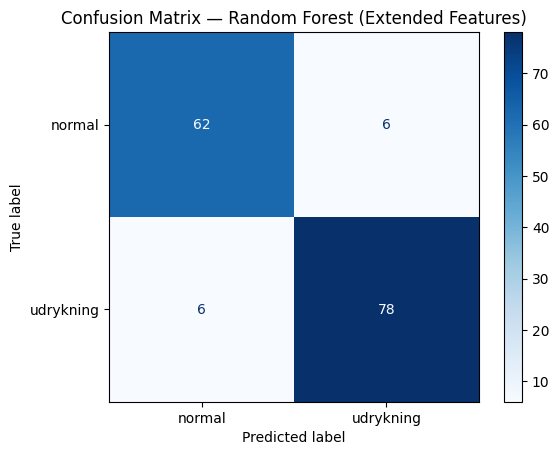

In [4]:
# ============================================================
# STEP 0 — Import og load
# ============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.stats import entropy, skew, kurtosis
from scipy.signal import welch

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, 
    classification_report,
    ConfusionMatrixDisplay
)

# Load sliding windows
X = np.load("X_windows.npy")     # shape: (N, 200, 3)
y = np.load("y_labels.npy")      # shape: (N,)

print("Loaded:")
print("X shape:", X.shape)
print("y shape:", y.shape)
print("Labels:", np.unique(y))


# ============================================================
# STEP 1 — Udvidet feature extractor
# ============================================================

def extract_stats(v):
    """Udvider statistiske features pr. akse."""
    p10, p25, p75, p90 = np.percentile(v, [10, 25, 75, 90])
    return [
        np.mean(v),
        np.std(v),
        np.var(v),
        np.min(v),
        np.max(v),
        np.median(v),

        p10, p25, p75, p90,

        np.sqrt(np.mean(v**2)),            # RMS
        np.sum(v**2),                      # Energy
        np.max(v) - np.min(v),             # Peak-to-peak
        np.mean(np.abs(v - np.mean(v))),   # MAD
        skew(v),
        kurtosis(v),
    ]


def extract_freq(v, fs=100):
    """Frekvensdomæne features."""
    freqs, psd = welch(v, fs=fs, nperseg=len(v))

    # Normaliser PSD til probabilistisk fordeling
    psd_norm = psd / np.sum(psd)

    # Dominant frekvens
    dominant_freq = freqs[np.argmax(psd)]

    # Spectral centroid
    centroid = np.sum(freqs * psd) / np.sum(psd)

    # Spectral entropy
    spec_entropy = entropy(psd_norm)

    # Båndenergi (0–5, 5–15, 15–40 Hz)
    band0_5  = np.sum(psd[(freqs >= 0) & (freqs < 5)])
    band5_15 = np.sum(psd[(freqs >= 5) & (freqs < 15)])
    band15_40 = np.sum(psd[(freqs >= 15) & (freqs < 40)])

    return [
        dominant_freq,
        centroid,
        spec_entropy,
        band0_5,
        band5_15,
        band15_40,
    ]


def extract_features(window, fs=100):
    x = window[:, 0]
    y_ = window[:, 1]
    z = window[:, 2]
    mag = np.sqrt(x**2 + y_**2 + z**2)

    features = []

    # Statistik + frekvens pr. akse
    for v in [x, y_, z]:
        features += extract_stats(v)
        features += extract_freq(v, fs)

    # Magnitude-features
    features += extract_stats(mag)
    features += extract_freq(mag, fs)

    # Korrelationsfeatures
    features += [
        np.corrcoef(x, y_)[0,1],
        np.corrcoef(x, z)[0,1],
        np.corrcoef(y_, z)[0,1]
    ]

    return features


# ============================================================
# STEP 2 — Kør feature extraction
# ============================================================

print("\nExtracting extended features…")

feature_list = [extract_features(win) for win in X]
F = np.array(feature_list)

print("Feature matrix shape:", F.shape)


# ============================================================
# STEP 3 — Label encoding
# ============================================================

le = LabelEncoder()
y_enc = le.fit_transform(y)

print("Label classes:", le.classes_)


# ============================================================
# STEP 4 — Train/test split
# ============================================================

X_train, X_test, y_train, y_test = train_test_split(
    F, y_enc, 
    test_size=0.2, 
    random_state=42, 
    stratify=y_enc
)

print("\nTrain:", X_train.shape)
print("Test :", X_test.shape)


# ============================================================
# STEP 5 — Random Forest
# ============================================================

print("\nTraining Random Forest…")

rf = RandomForestClassifier(
    n_estimators=400,
    max_depth=None,
    min_samples_split=2,
    n_jobs=-1,
    class_weight="balanced"
)

rf.fit(X_train, y_train)

print("Training done!")


# ============================================================
# STEP 6 — Evaluer model
# ============================================================

y_pred = rf.predict(X_test)

print("\nAccuracy:", accuracy_score(y_test, y_pred))
print("\nClassification report:\n", classification_report(y_test, y_pred, target_names=le.classes_))

disp = ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred, display_labels=le.classes_, cmap="Blues"
)
plt.title("Confusion Matrix — Random Forest (Extended Features)")
plt.show()

In [5]:
# ============================================================
# FEATURE IMPORTANCE — TABEL MED PROCENTVIS VÆRDI
# ============================================================

# Total importance (burde være 1.0 for RF)
total_importance = np.sum(importances)

# Lav tabel med navn, raw importance og procent
feature_importance_list = []

for idx in range(len(feature_names)):
    name = feature_names[idx]
    imp = importances[idx]
    perc = (imp / total_importance) * 100
    feature_importance_list.append((name, imp, perc))

# Sortér efter importance (størst først)
feature_importance_list.sort(key=lambda x: x[1], reverse=True)

# Print pænt
# Hvis du vil have det som DataFrame også:
importance_df = pd.DataFrame(feature_importance_list, 
                             columns=["feature", "importance", "percent"])

# Vis top 10 automatisk
print("\nTOP 10 FEATURES:\n")
display(importance_df.head(10))
top20 = importance_df.head(10)
print("Top 10 features dækker:", top10["percent"].sum(), "% af total importance")

NameError: name 'importances' is not defined

Antal feature names: 91
Antal features: 91
✔ Feature name list matches feature matrix.


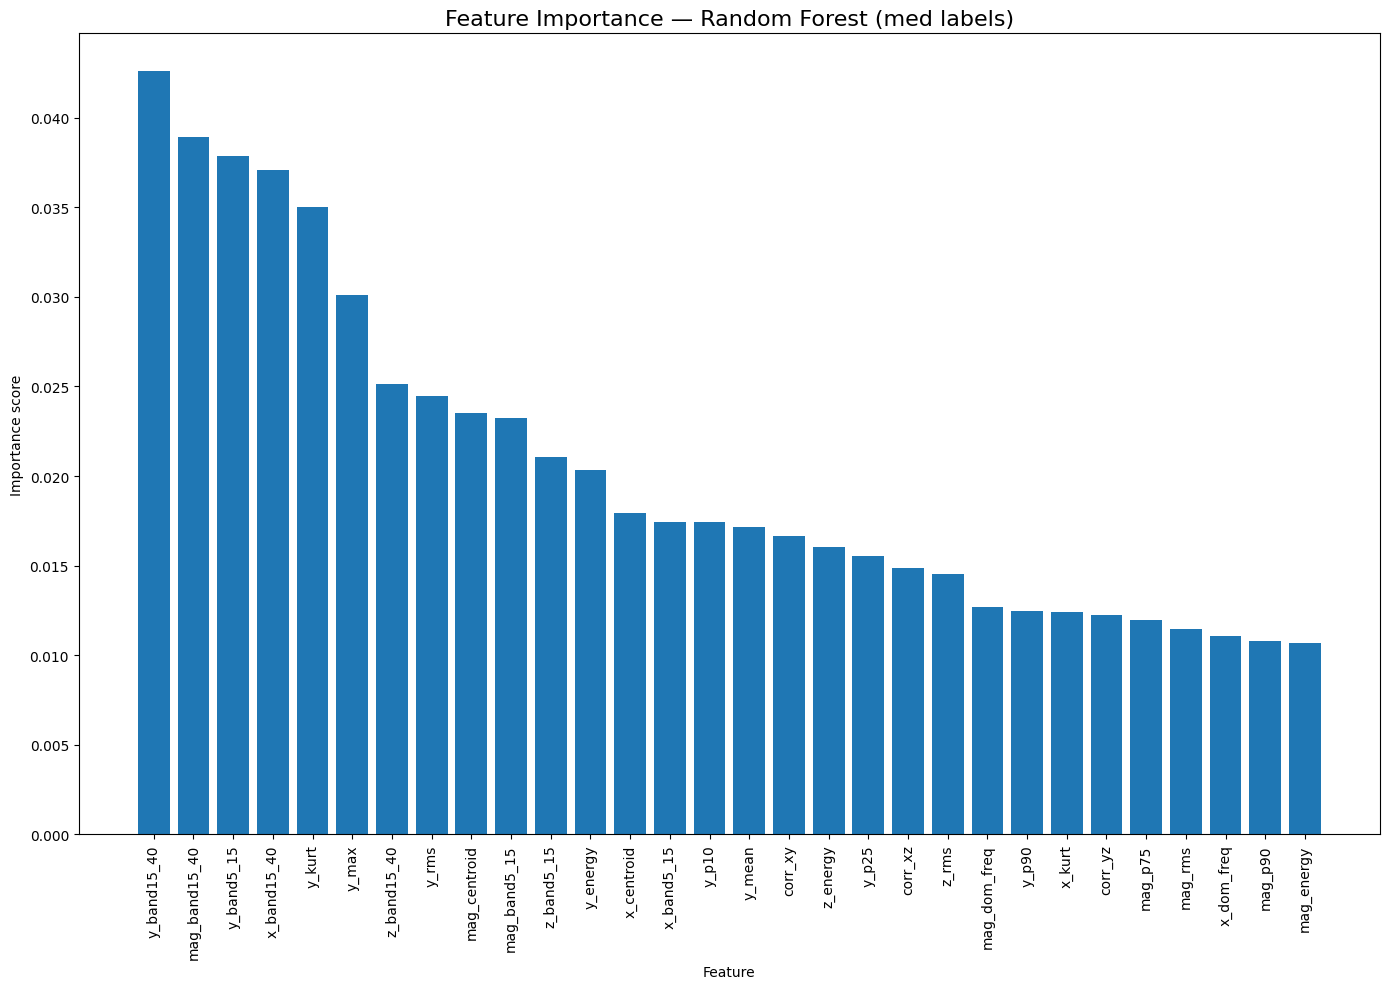

In [13]:
# ============================================================
# FEATURE IMPORTANCE — MED FEATURE NAVNE
# ============================================================

def get_feature_names():
    """Returnerer feature-navne i præcis samme rækkefølge som extract_features()."""
    names = []

    axes = ["x", "y", "z"]
    stats_names = [
        "mean", "std", "var", "min", "max", "median",
        "p10", "p25", "p75", "p90",
        "rms", "energy", "ptp", "mad", "skew", "kurt",
    ]

    freq_names = [
        "dom_freq", "centroid", "spec_entropy",
        "band0_5", "band5_15", "band15_40"
    ]

    # Stats + frekvens for hver akse
    for a in axes:
        for s in stats_names:
            names.append(f"{a}_{s}")
        for f in freq_names:
            names.append(f"{a}_{f}")

    # Magnitude-features
    for s in stats_names:
        names.append(f"mag_{s}")
    for f in freq_names:
        names.append(f"mag_{f}")

    # Korrelationsfeatures
    names += ["corr_xy", "corr_xz", "corr_yz"]

    return names


# Hent navne
feature_names = get_feature_names()

print("Antal feature names:", len(feature_names))
print("Antal features:", F.shape[1])

if len(feature_names) != F.shape[1]:
    print("⚠ ADVARSEL: Feature count mismatch! Tjek extract_features rækkefølge.")
else:
    print("✔ Feature name list matches feature matrix.")

# ============================================================
# PLOT — Top 30 vigtige features
# ============================================================

importances = rf.feature_importances_
sorted_idx = np.argsort(importances)[::-1]

top_n = 30  # kan ændres

plt.figure(figsize=(14, 10))
plt.title("Feature Importance — Random Forest (med labels)", fontsize=16)

plt.bar(range(top_n), importances[sorted_idx][:top_n])
plt.xticks(range(top_n),
           [feature_names[i] for i in sorted_idx[:top_n]],
           rotation=90)

plt.ylabel("Importance score")
plt.xlabel("Feature")
plt.tight_layout()
plt.show()


In [3]:
# ============================================================
# TEST — Random Forest med KUN de 10 vigtigste features
# ============================================================

print("===================================================")
print(" VALG AF TOP 10 FEATURES")
print("===================================================\n")

# 1️⃣  Hent top 10 features fra importance_df (allerede sorteret)
top10 = importance_df.head(10)
display(top10)
print("Top 10 features dækker:", top10["percent"].sum(), "% af total importance")
top10_names = top10["feature"].tolist()

# 2️⃣  Find deres indeks i feature matrix
top10_indices = [feature_names.index(name) for name in top10_names]

# 3️⃣  Udvælg de features fra F
F10 = F[:, top10_indices]
print("\nNy feature-matrix shape (F10):", F10.shape)

# 4️⃣  Train/test split
X_train10, X_test10, y_train10, y_test10 = train_test_split(
    F10, y_enc,
    test_size=0.2,
    random_state=42,
    stratify=y_enc
)

print("Train10:", X_train10.shape)
print("Test10 :", X_test10.shape)

# 5️⃣  Træn en ny Random Forest på kun 10 features
rf10 = RandomForestClassifier(
    n_estimators=400,
    class_weight="balanced",
    n_jobs=-1,
    random_state=42
)

rf10.fit(X_train10, y_train10)

# 6️⃣  Evaluer modellen
y_pred10 = rf10.predict(X_test10)

acc10 = accuracy_score(y_test10, y_pred10)
print("\n===================================================")
print(" RESULTATER MED KUN TOP 10 FEATURES")
print("===================================================\n")

print("Accuracy:", acc10)
print("\nClassification report:\n")
print(classification_report(y_test10, y_pred10, target_names=le.classes_))

# 7️⃣  Plot confusion matrix
disp = ConfusionMatrixDisplay.from_predictions(
    y_test10, y_pred10,
    display_labels=le.classes_,
    cmap="Blues"
)
plt.title("Confusion Matrix — Random Forest (Top 10 features)")
plt.show()

# 8️⃣ Print som tabel igen til MCU-forberedelse
print("\nTOP 10 FEATURES DER SKAL IMPLEMENTERES PÅ MCU:")
print("------------------------------------------------")
for i, name in enumerate(top10_names):
    print(f"{i+1:2d}. {name}")
print("Top 10 features dækker:", top10["percent"].sum(), "% af total importance")

 VALG AF TOP 10 FEATURES



NameError: name 'importance_df' is not defined

 VALG AF TOP 20 FEATURES



,feature,importance,percent
0,y_band15_40,0.042576,4.257642
1,mag_band15_40,0.038924,3.892359
2,y_band5_15,0.037857,3.785700
3,x_band15_40,0.037106,3.710632
4,y_kurt,0.034998,3.499844
5,y_max,0.030081,3.008067
6,z_band15_40,0.025124,2.512439
7,y_rms,0.024466,2.446617
8,mag_centroid,0.023515,2.351542
9,mag_band5_15,0.023246,2.324615



Top 20 features dækker: 49.22903491990273 % af total importance

Shape med 20 features (F20): (757, 20)
Train20: (605, 20)
Test20 : (152, 20)

 RESULTATER MED KUN TOP 20 FEATURES

Accuracy: 0.8947368421052632

Classification report:

              precision    recall  f1-score   support

      normal       0.87      0.90      0.88        68
   udrykning       0.91      0.89      0.90        84

    accuracy                           0.89       152
   macro avg       0.89      0.89      0.89       152
weighted avg       0.90      0.89      0.89       152



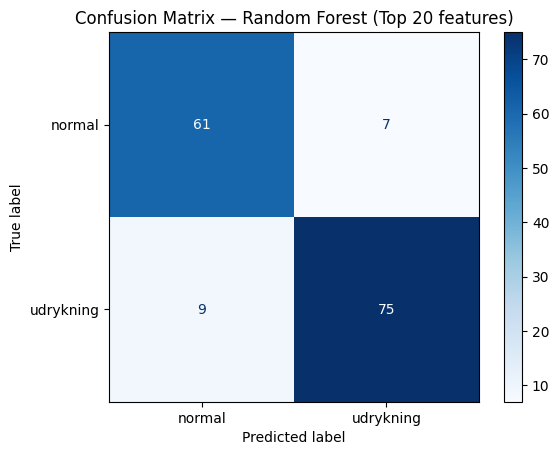


TOP 20 FEATURES (MCU-kandidater):
------------------------------------------------
 1. y_band15_40
 2. mag_band15_40
 3. y_band5_15
 4. x_band15_40
 5. y_kurt
 6. y_max
 7. z_band15_40
 8. y_rms
 9. mag_centroid
10. mag_band5_15
11. z_band5_15
12. y_energy
13. x_centroid
14. x_band5_15
15. y_p10
16. y_mean
17. corr_xy
18. z_energy
19. y_p25
20. corr_xz

Top 20 features dækker: 49.22903491990273 % af total importance


In [16]:
# ============================================================
# TEST — Random Forest med TOP 20 features
# ============================================================

print("===================================================")
print(" VALG AF TOP 20 FEATURES")
print("===================================================\n")

# 1️⃣ Tag de 20 vigtigste features
top20 = importance_df.head(20)
display(top20)
print("\nTop 20 features dækker:", top20["percent"].sum(), "% af total importance")

top20_names = top20["feature"].tolist()

# 2️⃣ Find index i det oprindelige feature array
top20_indices = [feature_names.index(name) for name in top20_names]

# 3️⃣ Lav feature-matrix med kun top 20 features
F20 = F[:, top20_indices]
print("\nShape med 20 features (F20):", F20.shape)

# 4️⃣ Train/test split
X_train20, X_test20, y_train20, y_test20 = train_test_split(
    F20, y_enc,
    test_size=0.2,
    random_state=42,
    stratify=y_enc
)

print("Train20:", X_train20.shape)
print("Test20 :", X_test20.shape)

# 5️⃣ Træn RF-model med top 20 features
rf20 = RandomForestClassifier(
    n_estimators=400,
    class_weight="balanced",
    n_jobs=-1,
    random_state=42
)

rf20.fit(X_train20, y_train20)

# 6️⃣ Evaluér
y_pred20 = rf20.predict(X_test20)

acc20 = accuracy_score(y_test20, y_pred20)
print("\n===================================================")
print(" RESULTATER MED KUN TOP 20 FEATURES")
print("===================================================\n")

print("Accuracy:", acc20)
print("\nClassification report:\n")
print(classification_report(y_test20, y_pred20, target_names=le.classes_))

# 7️⃣ Confusion matrix
disp = ConfusionMatrixDisplay.from_predictions(
    y_test20, y_pred20,
    display_labels=le.classes_,
    cmap="Blues"
)
plt.title("Confusion Matrix — Random Forest (Top 20 features)")
plt.show()

# 8️⃣ Udskriv feature-liste
print("\nTOP 20 FEATURES (MCU-kandidater):")
print("------------------------------------------------")
for i, name in enumerate(top20_names):
    print(f"{i+1:2d}. {name}")

# 9️⃣ Hvor stor procentdel importance dækker Top 20?
print("\nTop 20 features dækker:", top20["percent"].sum(), "% af total importance")

In [2]:
print(top10_indices)

NameError: name 'top10_indices' is not defined